In [3]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

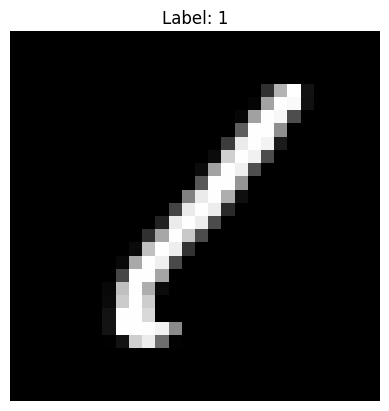

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_ds = datasets.MNIST(root="mnist", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="mnist", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

x0, y0 = next(iter(train_loader))
plt.figure()
plt.imshow(x0[0,0], cmap="gray")
plt.title(f"Label: {y0[0].item()}")
plt.axis("off")
plt.show()


In [6]:
class ThalamusGate(nn.Module):
    """
    Uproszczona bramka uwagi: uczy się wzmacniać / tłumić kanały.
    (inspiracja: wzgórze/LGN jako przekaźnik + gating)
    """
    def __init__(self, channels):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels)
        self.fc2 = nn.Linear(channels, channels)

    def forward(self, x):

        b, c, h, w = x.shape
        pooled = x.mean(dim=(2,3))
        g = torch.sigmoid(self.fc2(F.relu(self.fc1(pooled))))
        g = g.view(b, c, 1, 1)
        return x * g, g.squeeze(-1).squeeze(-1)


class VisualCortex(nn.Module):
    """
    V1/V2/V4 jako proste bloki conv.
    """
    def __init__(self):
        super().__init__()
        # "Retina" -> proste filtry
        self.retina = nn.Conv2d(1, 16, kernel_size=3, padding=1)

        # "Thalamus"
        self.thalamus = ThalamusGate(16)

        # "V1"
        self.v1 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 28->14
        )

        # "V2/V4"
        self.v2v4 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 14->7
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
        )

        # "IT" - embedding obiektu
        self.it = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.retina(x)
        x, gate = self.thalamus(x)
        x = self.v1(x)
        x = self.v2v4(x)
        emb = self.it(x)     # (B,128)
        return emb, gate


class HippocampusMemory:
    def __init__(self, max_items=2000, emb_dim=128, num_classes=10):
        self.max_items = max_items
        self.emb_dim = emb_dim
        self.num_classes = num_classes
        self.keys = None
        self.vals = None

    def __len__(self):
        return 0 if self.keys is None else self.keys.shape[0]

    @torch.no_grad()
    def add(self, emb, y, add_prob=0.2):
        mask = torch.rand(emb.shape[0]) < add_prob
        if mask.sum().item() == 0:
            return
        e = emb[mask].detach().cpu()
        v = y[mask].detach().cpu()

        if self.keys is None:
            self.keys = e
            self.vals = v
        else:
            self.keys = torch.cat([self.keys, e], dim=0)
            self.vals = torch.cat([self.vals, v], dim=0)

        if self.keys.shape[0] > self.max_items:
            overflow = self.keys.shape[0] - self.max_items
            self.keys = self.keys[overflow:]
            self.vals = self.vals[overflow:]

    def retrieve_logits(self, emb, topk=25):
        if self.keys is None or self.keys.shape[0] < 10:
            return None

        keys = self.keys.to(emb.device)
        vals = self.vals.to(emb.device)


        emb_n = F.normalize(emb, dim=-1)
        keys_n = F.normalize(keys, dim=-1)
        sim = emb_n @ keys_n.T

        k = min(topk, sim.shape[1])
        s_top, idx = torch.topk(sim, k=k, dim=1)
        v_top = vals[idx]

        logits = torch.zeros(emb.shape[0], self.num_classes, device=emb.device)
        weights = F.softmax(s_top, dim=1)

        logits.scatter_add_(1, v_top, weights)
        logits = torch.log(logits + 1e-8)
        return logits


class BasalGangliaGate(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, emb):
        return torch.sigmoid(self.net(emb)).squeeze(1)  # (B,)


class CerebellumDecoder(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.fc = nn.Linear(emb_dim, 64*7*7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 7->14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # 14->28
            nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, emb):
        x = self.fc(emb).view(-1, 64, 7, 7)
        return self.deconv(x)


class PFCClassifier(nn.Module):
    def __init__(self, emb_dim=128, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, emb):
        return self.net(emb)


class BrainNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.vision = VisualCortex()
        self.pfc = PFCClassifier(emb_dim=128, num_classes=num_classes)
        self.bg_gate = BasalGangliaGate(emb_dim=128)
        self.cerebellum = CerebellumDecoder(emb_dim=128)
        self.memory = HippocampusMemory(max_items=2000, emb_dim=128, num_classes=num_classes)

    def forward(self, x, use_memory=True):
        emb, thalamus_gate = self.vision(x)
        cortex_logits = self.pfc(emb)

        if (not use_memory):
            return cortex_logits, emb, thalamus_gate, None

        mem_logits = self.memory.retrieve_logits(emb)
        if mem_logits is None:
            return cortex_logits, emb, thalamus_gate, None

        g = self.bg_gate(emb)
        mixed = (1 - g).unsqueeze(1) * cortex_logits + g.unsqueeze(1) * mem_logits
        return mixed, emb, thalamus_gate, g


In [7]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits, emb, _, _ = model(x, use_memory=True)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return correct / total

def pretrain_self_supervised(model, loader, epochs=1, lr=1e-3):
    model.train()
    opt = torch.optim.Adam(list(model.vision.parameters()) + list(model.cerebellum.parameters()), lr=lr)

    losses = []
    for ep in range(epochs):
        for x, _ in loader:
            x = x.to(device)
            emb, _ = model.vision(x)
            recon = model.cerebellum(emb)
            loss = F.mse_loss(recon, x)

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses.append(loss.item())
        print(f"[Pretrain] epoch {ep+1}/{epochs} | last loss: {losses[-1]:.4f}")
    return losses

def train_classifier(model, loader, epochs=2, lr=1e-3, lambda_recon=0.2, memory_add_prob=0.25):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    loss_hist = []
    acc_hist = []

    for ep in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            logits, emb, _, g = model(x, use_memory=True)

            loss_cls = F.cross_entropy(logits, y)

            recon = model.cerebellum(emb)
            loss_rec = F.mse_loss(recon, x)

            loss = loss_cls + lambda_recon * loss_rec

            opt.zero_grad()
            loss.backward()
            opt.step()

            model.memory.add(emb, y, add_prob=memory_add_prob)

            loss_hist.append(loss.item())

        acc = evaluate(model, test_loader)
        acc_hist.append(acc)
        mem_size = len(model.memory)
        g_info = "" if g is None else f", avg gate={g.mean().item():.2f}"
        print(f"[Train] epoch {ep+1}/{epochs} | test acc={acc:.4f} | memory={mem_size}{g_info}")

    return loss_hist, acc_hist


[Pretrain] epoch 1/1 | last loss: 0.0431
[Train] epoch 1/2 | test acc=0.8609 | memory=2000, avg gate=0.05
[Train] epoch 2/2 | test acc=0.9242 | memory=2000, avg gate=0.05


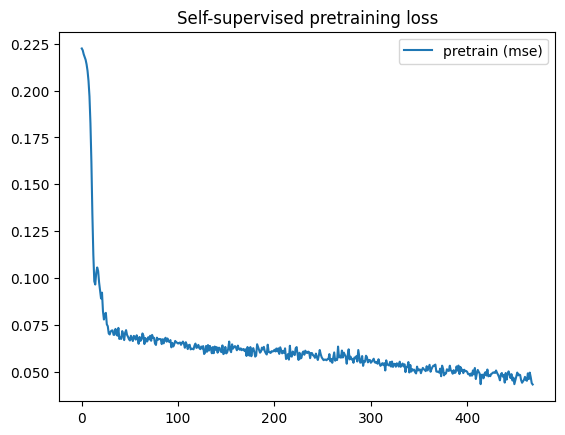

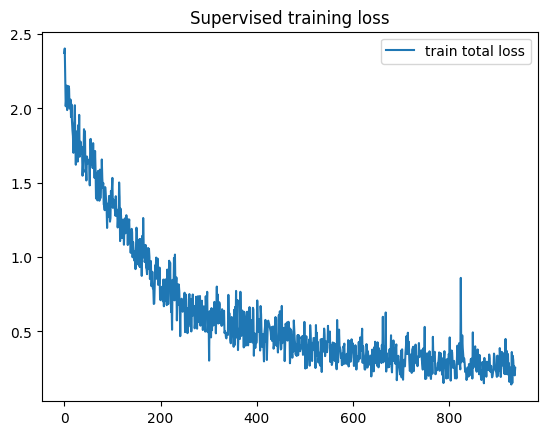

Final test accuracy: 0.9242


In [8]:
model = BrainNet(num_classes=10).to(device)

pre_losses = pretrain_self_supervised(model, train_loader, epochs=1, lr=1e-3)

train_losses, acc_hist = train_classifier(model, train_loader, epochs=2, lr=1e-3, lambda_recon=0.2)

plt.figure()
plt.plot(pre_losses, label="pretrain (mse)")
plt.legend()
plt.title("Self-supervised pretraining loss")
plt.show()

plt.figure()
plt.plot(train_losses, label="train total loss")
plt.legend()
plt.title("Supervised training loss")
plt.show()

print("Final test accuracy:", evaluate(model, test_loader))


True labels:  [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5]
Pred labels:  [7, 2, 1, 0, 4, 1, 4, 4, 5, 9, 0, 6, 9, 0, 1, 5]
Basal ganglia gate (memory trust) avg: 0.07647854089736938
Thalamus gate mean per-channel (first sample):
[0.614 0.854 0.94  0.968 0.816 0.722 0.525 0.69  0.393 0.793 0.871 0.392
 0.816 0.83  0.989 0.685]


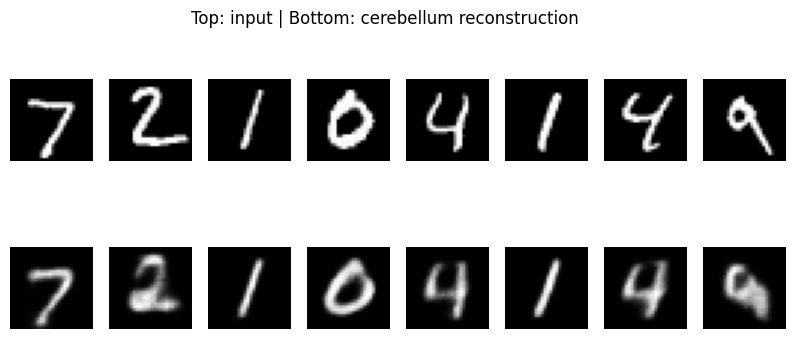

In [9]:
model.eval()
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

with torch.no_grad():
    logits, emb, th_gate, g = model(x[:16], use_memory=True)
    recon = model.cerebellum(emb)

pred = logits.argmax(dim=1)

print("True labels: ", y[:16].tolist())
print("Pred labels: ", pred[:16].tolist())

if g is not None:
    print("Basal ganglia gate (memory trust) avg:", float(g.mean().item()))

print("Thalamus gate mean per-channel (first sample):")
print(th_gate[0].detach().cpu().numpy().round(3))

plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(x[i,0].detach().cpu(), cmap="gray")
    plt.axis("off")
    plt.subplot(2,8,8+i+1)
    plt.imshow(recon[i,0].detach().cpu(), cmap="gray")
    plt.axis("off")
plt.suptitle("Top: input | Bottom: cerebellum reconstruction")
plt.show()